In [1]:
import json
import os
import numpy as np
import pandas as pd
from scipy.interpolate import griddata, RBFInterpolator
from scipy import optimize
from bmn.brezin import compute_Brezin_energy

import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5.0
plt.rcParams["xtick.minor.size"] = 3.0
plt.rcParams["ytick.major.size"] = 5.0
plt.rcParams["ytick.minor.size"] = 3.0
plt.rcParams["lines.linewidth"] = 2
plt.rc("font", family="serif", size=16)
matplotlib.rc("text", usetex=True)
matplotlib.rc("legend", fontsize=16)
matplotlib.rcParams["axes.prop_cycle"] = cycler(
    color=["#E24A33", "#348ABD", "#988ED5", "#777777", "#FBC15E", "#8EBA42", "#FFB5B8"]
)
matplotlib.rcParams.update(
    {"axes.grid": True, "grid.alpha": 0.75, "grid.linewidth": 0.5}
)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
def load_data(
        datadir,
        names_in_filename,
        tol=1e-6,
        ):

    # grab the data files
    names_in_filename.append('.json')
    files = []
    for f in os.listdir(datadir):
        if all(name in f for name in names_in_filename):
            files.append(f)
    print(f"number of files found: {len(files)}")

    # build dataframe
    data = []
    for file in files:
        with open(f"{datadir}/{file}") as f:
            result = json.load(f)
        del result["param"] # remove param vector
        #result["energy"] = float(file.split('_')[1][:-5]) # add g4 coupling
        result["filename"] = file
        if result["max_quad_constraint_violation"] < tol:
            data.append(result)
    df = pd.DataFrame(data)
    df.sort_values("energy", inplace=True)

    max_violation_linear = df["violation_of_linear_constraints"].max()
    max_violation_quadratic = df["max_quad_constraint_violation"].max()
    max_violation_PSD = df["min_bootstrap_eigenvalue"].abs().max()

    print(f"number of loaded data points: {len(data)}")
    print(f"max violation of linear constraints:{max_violation_linear:.4e}")
    print(f"max violation of PSD constraints:{max_violation_PSD:.4e}\n")
    print(f"max violation of quadratic constraints:{max_violation_quadratic:.4e}")

    return df.copy()

## Miscellaneous

In [ ]:
def n(L, d):
    return ((2*d)**(L+1) - 1) / ((2*d) - 1)

L_list = [i for i in range(2, 7)]
d = 2

fig, ax = plt.subplots(figsize=(7, 5))
for idx, d in enumerate(range(1, 4)):
    #ax.plot(L_list, [n(L, d=d)**2 for L in L_list], '--o', label="$n(L)^2$", color=colors[idx])
    ax.plot(L_list, [n(2*L, d=d) for L in L_list], '-o', label="$n(2L)$", color=colors[idx])
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"count")
ax.legend()
#    ax.set_title(f"Growth of operators for d={d}")
ax.set_yscale('log')
plt.show()

## One Matrix

In [61]:
data = []
for L in [3, 4]:
    path =f"data/OneMatrix_L_{L}"
    files = [f for f in os.listdir(path) if ".json" in f]
    print(f"L={L}, number of data points found: {len(files)}")

    for file in files:
        with open(f"{path}/{file}") as f:
            result = json.load(f)
        del result["param"] # remove param vector
        if result["max_quad_constraint_violation"] < 1e-2:
            result["L"] = int(L)
            result["g2"] = float(file.split('_')[1])
            result["g4"] = float(file.split('_')[3])
            result["g6"] = float(file.split('_')[5][:-5])
            data.append(result)

df = pd.DataFrame(data)
df.sort_values("energy", inplace=True)
df.head(10)

L=3, number of data points found: 2280
L=4, number of data points found: 436


,prob.status,prob.value,maxiters_cvxpy,||x-init||,violation_of_linear_constraints,min_bootstrap_eigenvalue,max_quad_constraint_violation,quad_constraint_violation_norm,tr(1),energy,x_2,x_4,p_2,p_4,L,g2,g4,g6
174,optimal_inaccurate,-110.589177,10000,1.464005e-08,6.560763e-06,-5.610475e-09,6.330973e-06,6.552385e-06,1.0,-117.239971,9.185908,86.340625,1.414247,3.398042,3,-1.0,-16.000000,1.684211
189,optimal_inaccurate,-115.903141,10000,2.631753e-01,4.847920e-08,-2.967651e-05,1.975633e-07,2.033226e-07,1.0,-116.115453,8.157609,85.088249,0.082124,0.204937,3,-1.0,-16.000000,0.842105
1279,optimal_inaccurate,-115.661786,10000,1.254009e-02,4.751360e-08,-2.939791e-05,4.564744e-08,6.409268e-08,1.0,-115.872850,8.343495,89.572371,0.078547,0.199701,3,-1.0,-15.157895,0.842105
857,optimal_inaccurate,-115.448318,10000,2.412511e-01,2.190731e-08,-2.121181e-05,2.057571e-08,2.757172e-08,1.0,-115.635917,5.455892,86.762302,0.070729,0.058742,3,0.0,-16.000000,0.842105
9,optimal_inaccurate,-115.389564,10000,6.849664e-02,4.622761e-08,-2.902879e-05,2.908792e-07,2.943673e-07,1.0,-115.599033,8.535847,94.555745,0.074386,0.194268,3,-1.0,-14.315789,0.842105
704,optimal_inaccurate,-114.785349,10000,3.845087e-01,5.973696e-09,-3.948317e-06,8.642296e-08,9.570572e-08,1.0,-114.956198,5.825894,91.041763,0.065889,0.085129,3,0.0,-15.157895,0.842105
425,optimal_inaccurate,-113.642448,10000,1.328052e-01,4.281042e-09,-1.161757e-06,1.238261e-07,1.239701e-07,1.0,-113.811719,5.061896,86.696817,0.145108,0.256313,3,1.0,-16.000000,0.842105
125,optimal_inaccurate,-113.064934,10000,7.800934e-02,6.239052e-08,-3.659018e-05,8.049862e-08,9.950189e-08,1.0,-113.290070,6.856192,100.925494,0.044673,0.143691,3,0.0,-13.473684,0.842105
1586,optimal_inaccurate,-110.978447,10000,2.553335e-03,1.975114e-06,-1.447992e-03,1.790567e-06,1.973583e-06,1.0,-113.112302,10.232646,120.358391,0.148820,0.189660,3,-1.0,-10.947368,0.842105
143,optimal_inaccurate,-112.580507,10000,4.622497e-01,5.403623e-09,-1.298899e-06,1.845248e-07,2.920546e-07,1.0,-112.749649,5.510016,90.780436,0.125559,0.285697,3,1.0,-15.157895,0.842105


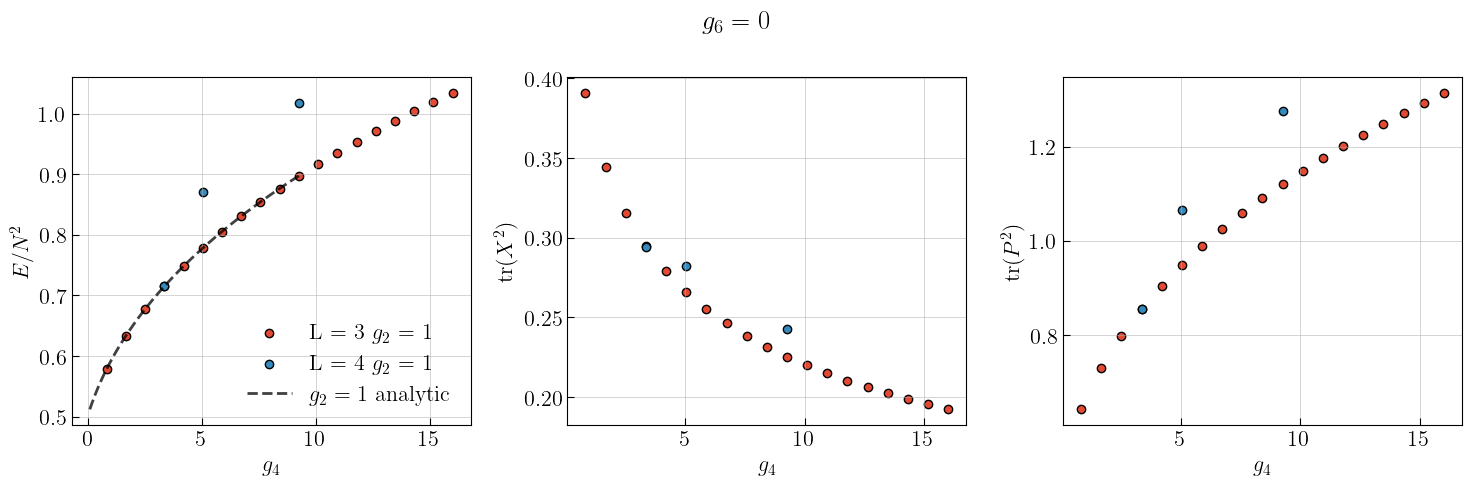

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for L in [3, 4]:
    for g2 in [1]:

        df2 = df[(df["g6"] == 0) & (df["g2"] == g2) & (df["L"] == L)].sort_values("g4")
        g4_max = df2["g4"].max()
        g4_list = np.linspace(0.1, g4_max, 100)

        ax[0].scatter(df2["g4"], df2["energy"], edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")
        ax[0].set_xlabel(r"$g_4$")
        ax[0].set_ylabel(r"$E/N^2$")

        ax[1].scatter(df2["g4"], df2["x_2"], edgecolors="k")
        ax[1].set_xlabel(r"$g_4$")
        ax[1].set_ylabel(r"tr$(X^2)$")

        ax[2].scatter(df2["g4"], df2["p_2"], edgecolors="k")
        ax[2].set_xlabel(r"$g_4$")
        ax[2].set_ylabel(r"tr$(P^2)$")

ax[0].plot(
    g4_list,
    [compute_Brezin_energy(g/4) for g in g4_list],
    '--',
    color='k',
    alpha=0.75,
    label=r"$g_2 = 1$ analytic"
    )

#[ax[i].set_xlim([0, 1.02 * g4_max]) for i in range(3)]
ax[0].legend(frameon=False)
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

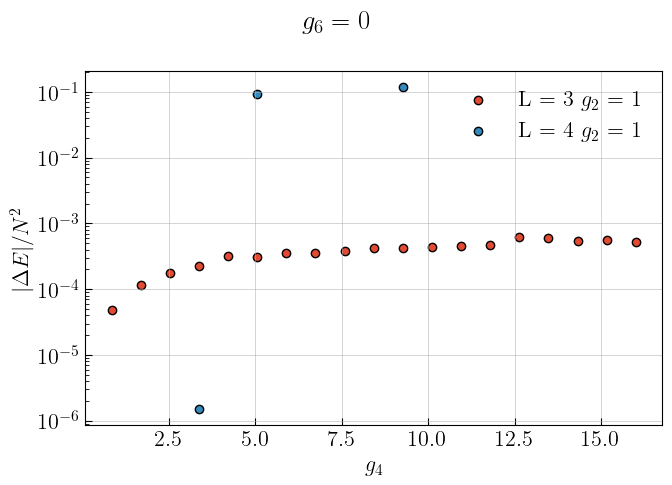

In [27]:
fig, ax = plt.subplots(figsize=(7, 5))

for L in [3, 4]:
    df2 = df[(df["g6"] == 0) & (df["g2"] == 1) & (df["L"] == L)].sort_values("g4")
    Brezin_energy = np.asarray([compute_Brezin_energy(g/4) for g in df2["g4"]])
    ax.scatter(df2["g4"], np.abs(Brezin_energy - df2["energy"]), edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$|\Delta E|/N^2$")
ax.legend(frameon=False)
ax.set_yscale('log')
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

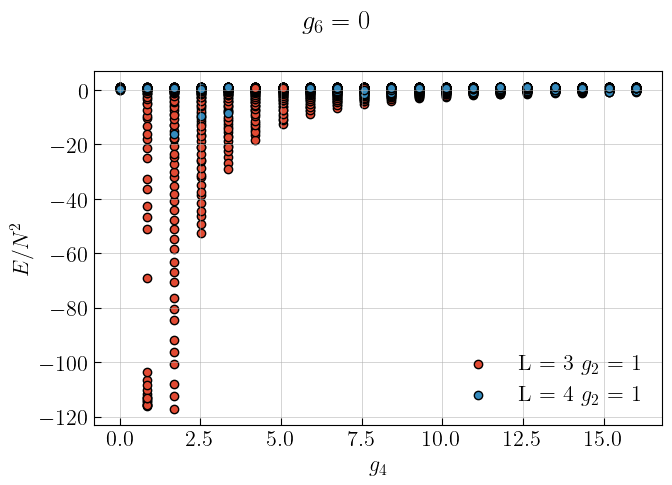

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))

for L in [3, 4]:
    df2 = df[(df["L"] == L)].sort_values("g4")
    ax.scatter(df2["g6"], df2["energy"], edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$E/N^2$")
ax.legend(frameon=False)
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

In [ ]:
df2 = df[(df["g2"] == 0) & (df["L"] == 3) & (df["g4"] < 3)]

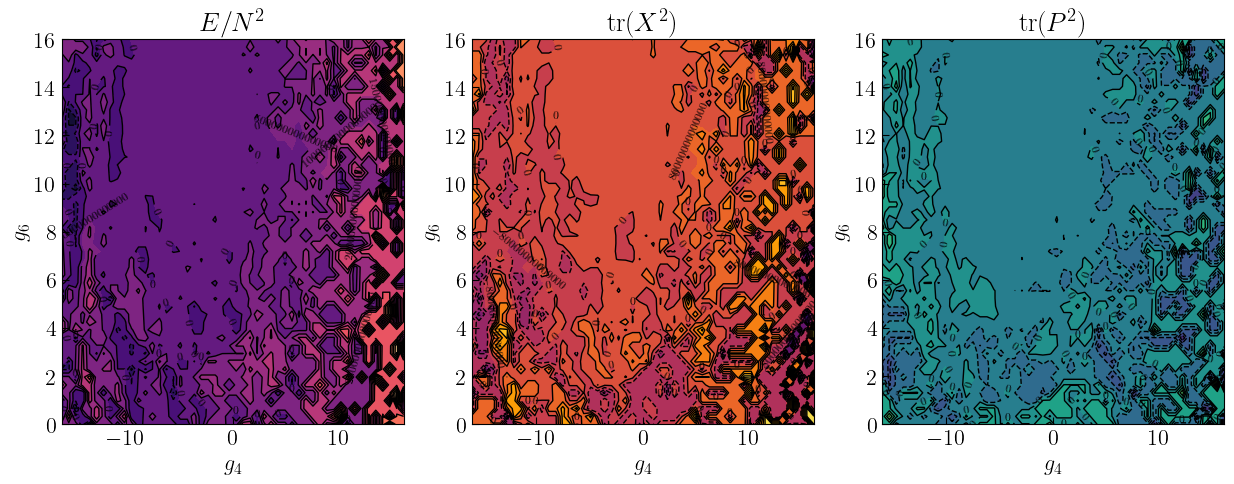

In [7]:
# Extracting x, y, z values
x = df2['g4'].values
y = df2['g6'].values

# Create grid values for x and y
xi = np.linspace(min(x), max(x), 50)
yi = np.linspace(min(y), max(y), 50)
xi, yi = np.meshgrid(xi, yi)

# Create the contour plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
[ax[i].grid(False) for i in range(3)]

# Interpolate z values on the grid
z = df2['energy'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[0].contourf(xi, yi, zi, levels=15, cmap='magma')
contour_lines = ax[0].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[0].clabel(contour_lines, inline=True, fontsize=8)
#ax[0].colorbar(contour)
ax[0].set_xlabel(r"$g_4$")
ax[0].set_ylabel(r"$g_6$")
ax[0].set_title(r"$E/N^2$")

z = df2['x_2'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[1].contourf(xi, yi, zi, levels=15, cmap='inferno')
contour_lines = ax[1].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[1].clabel(contour_lines, inline=True, fontsize=8)
ax[1].set_xlabel(r"$g_4$")
ax[1].set_ylabel(r"$g_6$")
ax[1].set_title(r"tr$(X^2)$")

z = df2['p_2'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[2].contourf(xi, yi, zi, levels=15, cmap='viridis')
contour_lines = ax[2].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[2].clabel(contour_lines, inline=True, fontsize=8)
ax[2].set_xlabel(r"$g_4$")
ax[2].set_ylabel(r"$g_6$")
ax[2].set_title(r"tr$(P^2)$")

plt.show()

## Two Matrix

Case with $m=1$, should match Han et al

In [28]:
datadir = "data/TwoMatrix_L_3_symmetric"
files = [f for f in os.listdir(datadir) if '.json' in f]

data = []
for file in files:
    if 'g4_' in file:
        with open(f"{datadir}/{file}") as f:
            result = json.load(f)
        del result["param"] # remove param vector
        result["g4"] = float(file[3:-5]) # add g4 coupling
        data.append(result)
print(f"number of data points found: {len(data)}")
df = pd.DataFrame(data)
df.sort_values("g4", inplace=True)
df.head(5)

number of data points found: 101


,prob.status,prob.value,maxiters_cvxpy,||x-init||,violation_of_linear_constraints,min_bootstrap_eigenvalue,max_quad_constraint_violation,quad_constraint_violation_norm,tr(1),energy,x_2,x_4,p_2,p_4,neg_commutator_squared,g4
69,optimal_inaccurate,1.035661,10000,8.232719,1.024736e-13,-2.217587e-09,3.246282e-08,4.376516e-08,1.0,1.006155,0.988068,0.974132,1.012184,1.025426,0.485481,0.0500
43,optimal_inaccurate,1.024389,10000,0.630661,2.164641e-11,-7.206370e-08,9.366663e-11,1.239047e-10,1.0,1.023408,0.957447,0.916776,1.045394,1.096888,0.452539,0.1995
12,optimal_inaccurate,1.040290,10000,1.465881,3.721798e-14,-5.002174e-13,4.985213e-07,5.297370e-07,1.0,1.039305,0.932539,0.870770,1.074894,1.163648,0.426221,0.3490
13,optimal_inaccurate,1.055174,10000,0.680977,3.771704e-14,-4.061791e-12,8.887929e-08,1.168789e-07,1.0,1.054157,0.911316,0.831041,1.101771,1.225053,0.404366,0.4985
97,optimal_inaccurate,1.070812,10000,0.344337,1.576517e-14,-4.180870e-09,3.172732e-08,4.626351e-08,1.0,1.068070,0.893290,0.800088,1.126330,1.286353,0.386572,0.6480


In [29]:
df.sort_values("max_quad_constraint_violation", inplace=False, ascending=False).head(5)

,prob.status,prob.value,maxiters_cvxpy,||x-init||,violation_of_linear_constraints,min_bootstrap_eigenvalue,max_quad_constraint_violation,quad_constraint_violation_norm,tr(1),energy,x_2,x_4,p_2,p_4,neg_commutator_squared,g4
51,optimal_inaccurate,1.342206,10000,0.553133,6.649803e-14,-1.632783e-11,9.909668e-07,1.454877e-06,1.0,1.340679,0.680938,0.483363,1.560593,2.540216,0.215101,5.4320
72,optimal_inaccurate,1.118294,10000,1.043662,1.193004e-12,-7.599881e-10,9.860872e-07,1.064819e-06,1.0,1.117193,0.838759,0.707358,1.210004,1.499995,0.335102,1.2460
39,optimal_inaccurate,2.284216,10000,0.017246,8.086198e-12,-8.372653e-07,7.173570e-07,9.477213e-07,1.0,1.335191,0.682442,0.482432,1.552774,2.504985,0.215730,5.2825
7,optimal_inaccurate,2.069113,10000,0.100066,1.597167e-12,-4.802069e-08,7.061550e-07,7.167299e-07,1.0,1.353420,0.672967,0.470686,1.580237,2.596240,0.209665,5.7310
75,optimal_inaccurate,1.106740,10000,0.937842,7.584836e-11,-8.787451e-08,7.033855e-07,9.205870e-07,1.0,1.105570,0.851228,0.729641,1.190351,1.453697,0.346306,1.0965


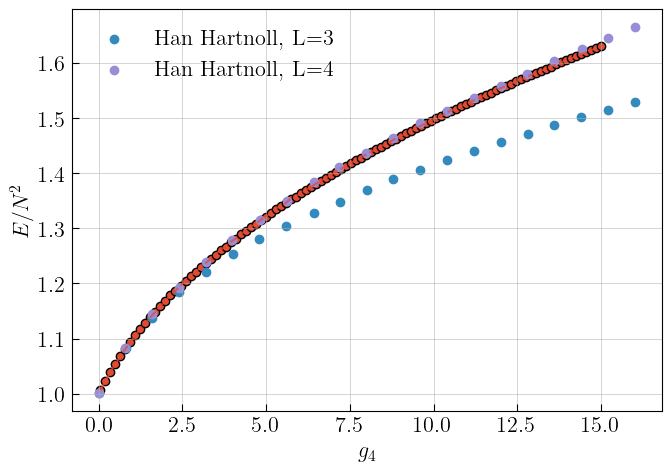

In [30]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(df["g4"], df["energy"], edgecolors="k")
ax.plot(df["g4"], df["energy"], '--', linewidth=1.5, alpha=0.75)

df_han_hartnoll_fig3a = pd.read_csv("data/data_from_papers/han_hartnoll_data/TwoMatrixFig3a_L_3.csv", header=None, names=["x", "y"])
ax.scatter(2 * df_han_hartnoll_fig3a["x"], 0.5 * df_han_hartnoll_fig3a["y"], label="Han Hartnoll, L=3")

df_han_hartnoll_fig3a = pd.read_csv("data/data_from_papers/han_hartnoll_data/TwoMatrixFig3a_L_4.csv", header=None, names=["x", "y"])
ax.scatter(2 * df_han_hartnoll_fig3a["x"], 0.5 * df_han_hartnoll_fig3a["y"], label="Han Hartnoll, L=4")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$E/N^2$")
ax.legend(frameon=False)
plt.tight_layout()
#ax.set_xlim([0.1, 1.4])
plt.show()

Case with $m=0$, can be thought of as a $d=2$ version of Mini-BFSS.

In [63]:
datadir = "data/TwoMatrix_L_3_symmetric_energy_fixed_g2_0"
datadir = "data/TwoMatrix_L_3_energy_fixed_g2_0"

df_x2 = load_data(
    datadir=datadir,
    names_in_filename=['energy', 'x_2'],
    tol=1e-4,
)

df_x4 = load_data(
    datadir=datadir,
    names_in_filename=['energy', 'x_4'],
    tol=1e-4,
)

df_commutator = load_data(
    datadir=datadir,
    names_in_filename=['energy', 'neg_commutator_squared'],
    tol=1e-4,
)

number of files found: 21
number of loaded data points: 21
max violation of linear constraints:4.9908e-09
max violation of PSD constraints:1.1853e-06

max violation of quadratic constraints:2.4748e-07
number of files found: 21
number of loaded data points: 21
max violation of linear constraints:1.5045e-07
max violation of PSD constraints:2.9037e-04

max violation of quadratic constraints:1.8319e-07
number of files found: 21
number of loaded data points: 21
max violation of linear constraints:2.3209e-08
max violation of PSD constraints:6.5812e-06

max violation of quadratic constraints:9.1610e-07


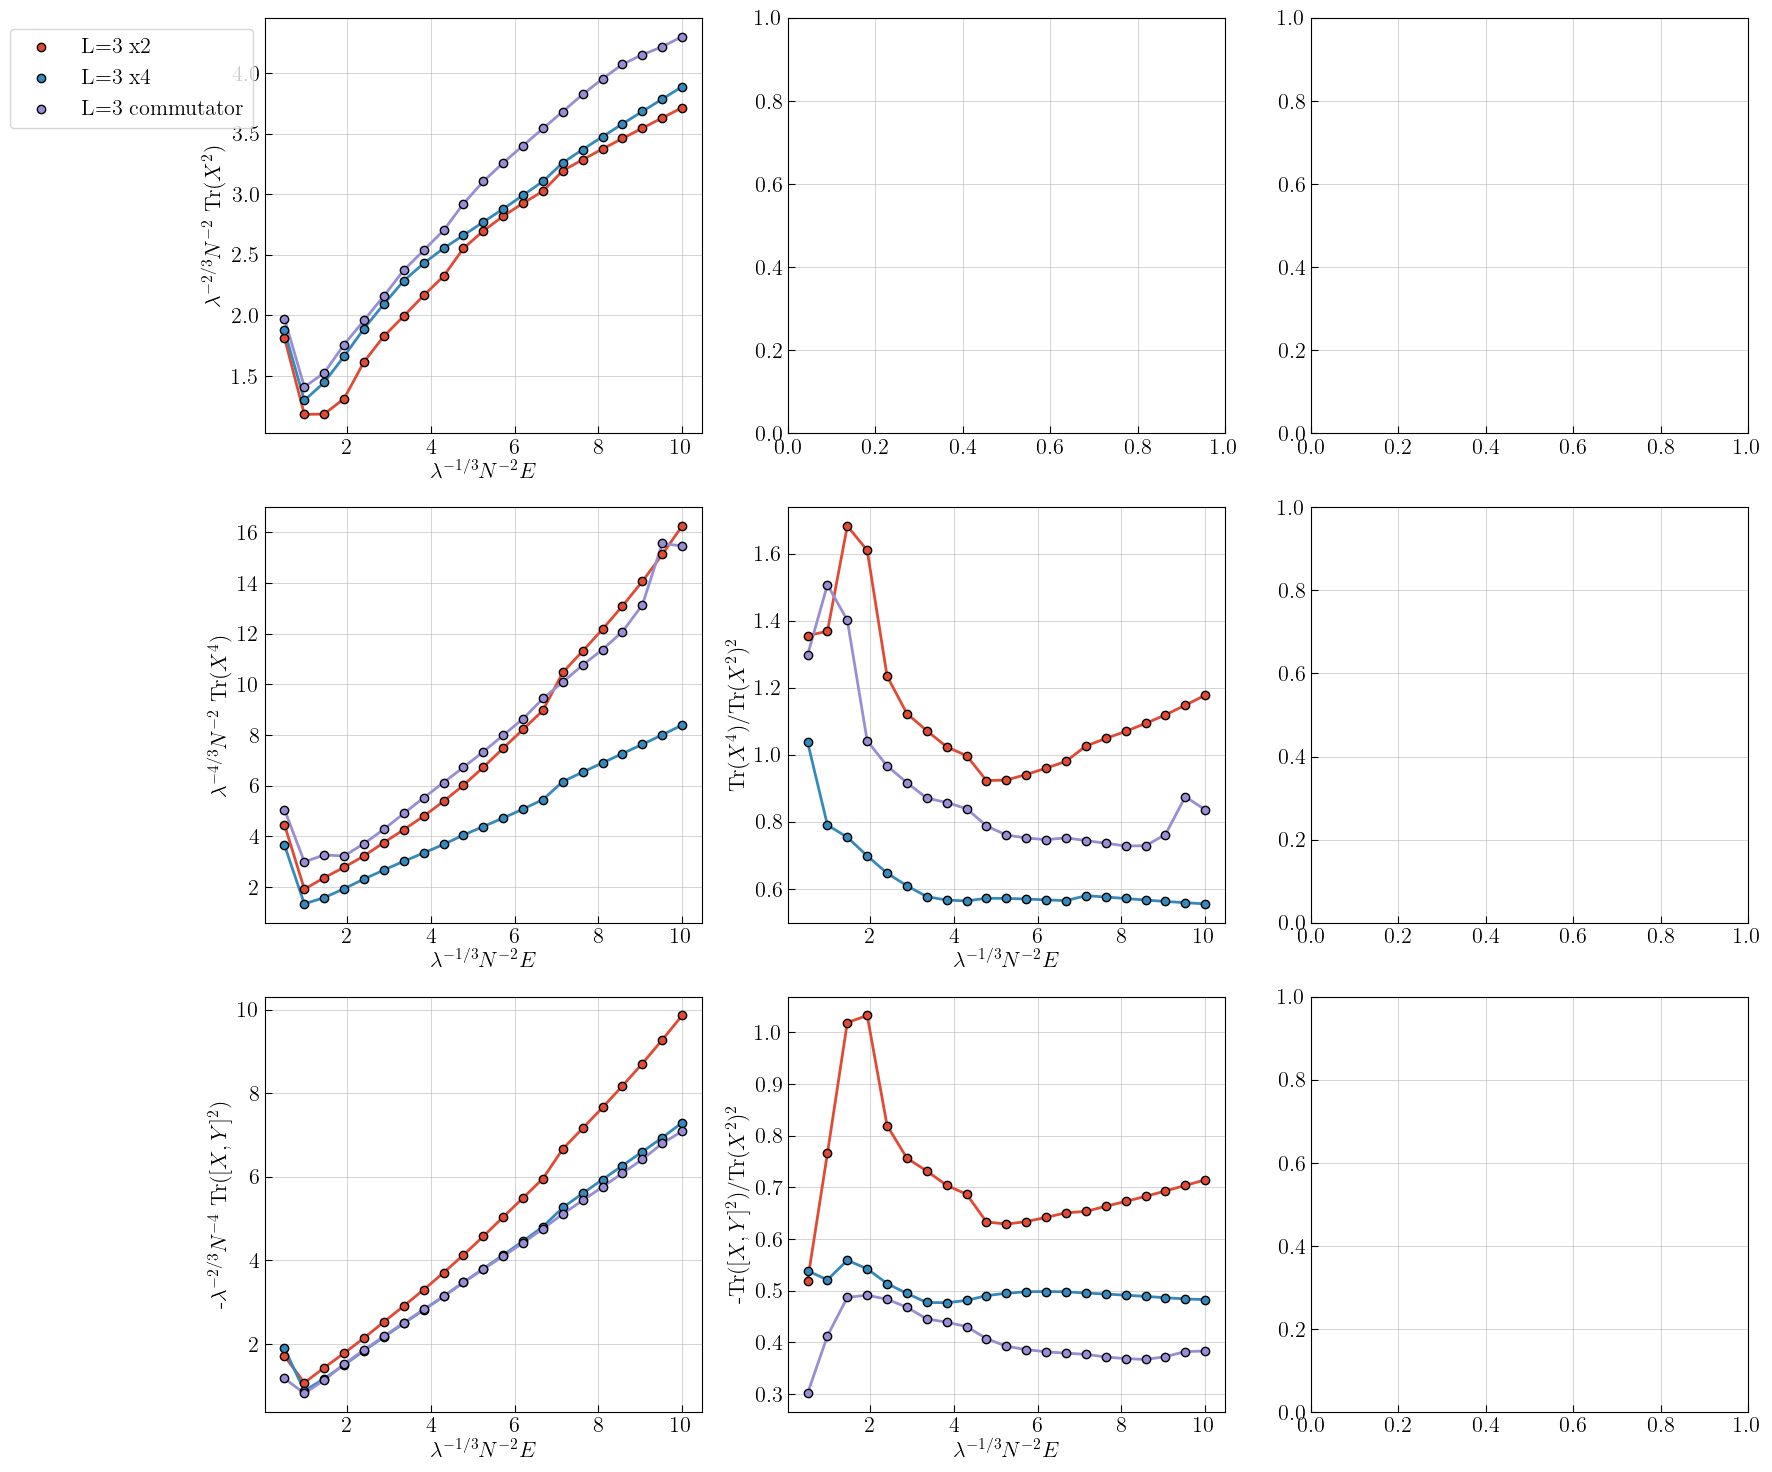

In [64]:
fig, axes = plt.subplots(3, 3, figsize=(3*6, 3*5))

ax = axes[0,0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["x_2"])
    ax.scatter(df["energy"], df["x_2"], label='L=3 ' + name, edgecolor='k', zorder=10)
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_ylim([min(lower_bound), 1])
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
ax.legend(fontsize=16, bbox_to_anchor=(0,1))

ax = axes[1, 0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["x_4"])
    ax.scatter(df["energy"], df["x_4"], label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-4/3} N^{-2}$ Tr$(X^4)$")

ax = axes[1, 1]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["x_4"]/df["x_2"]**2)
    ax.scatter(df["energy"], df["x_4"]/df["x_2"]**2, label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"Tr$(X^4)$/Tr$(X^2)^2$")

ax = axes[2, 0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["neg_commutator_squared"])
    ax.scatter(df["energy"], df["neg_commutator_squared"], label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"-$\lambda^{-2/3} N^{-4}$ Tr$([X, Y]^2)$")

ax = axes[2, 1]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["neg_commutator_squared"] / df["x_2"]**2)
    ax.scatter(df["energy"], df["neg_commutator_squared"] / df["x_2"]**2, label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"-Tr$([X, Y]^2)/$Tr$(X^2)^2$")

plt.tight_layout()
plt.show()

## BFSS

In [14]:
df_berkowitz = pd.read_csv("data/data_from_papers/Berkowits et al 1606.04951.csv", header=0)
df_berkowitz

,T,N,L,energy,R squared
0,0.4,32,32,0.629,3.4016
1,0.5,32,32,0.955,3.4386
2,0.6,32,16,1.442,3.3306
3,0.7,32,16,1.850,3.3771
4,0.8,32,16,2.340,3.4216
5,0.9,32,16,2.835,3.4643
6,1.0,32,16,3.386,3.3860


In [15]:
def lin_lower_bound_x2(energy: float) -> float:
    # eq 2.18 and 2.19 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # v is an auxiliary variable
    eq2_19 = lambda v: energy**2 + 3**9 / (energy + 3 * v) - 9 * v**2
    sol = optimize.root(eq2_19, [0])
    v = sol.x.item()
    lower_bound = (energy - 3*v)**2 / (9**3 * 16) + 27 / (8 * (energy + 3 * v))
    return lower_bound

def lin_lower_bound_x4(energy: float) -> float:
    # eq 2.20 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # y is the bound
    eq2_20 = lambda y: (energy/9 + 24*y) * (144 * np.sqrt(y) - (energy/9 - 24*y)**2) - 54
    sol = optimize.root(eq2_20, [0])
    return sol.x.item()

def lin_lower_bound_x4_bosonic(energy: float) -> float:
    # eq 2.13 of https://doi.org/10.1007/JHEP06(2023)038
    # includes only bosons
    # y is the bound
    eq2_13 = lambda y: np.sqrt(y) * (144 * y + 2/3*energy) - 9/4
    sol = optimize.root(eq2_13, [0])
    return sol.x.item()

def lin_upper_bound_commutator(energy: float) -> float:
    # TODO in progress!
    # eq 2.23 and 2.24 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # v is an auxiliary variable
    eq2_24 = lambda v: (energy - 3*v) * (energy + 3*v)**2 - 2*3**9
    eq2_23_RHS = lambda v: (v / 18) * ( 4 * (energy - 3*v)**2/(9**3 * 16) + 27 / (8 * (energy + 3*v))) ** (-2)
    sol = optimize.minimize(eq2_24, [2])
    v = sol.x.item()
    #factor = ( 4 * (energy - 3*v)**2/(9**3 * 16) + 27 / (8 * (energy + 3*v))) ** 2
    #lower_bound = (v / 18) / factor
    return eq2_23_RHS(v)

In [17]:
df_x2 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'x_2'],
    tol=1e-4,
)

df_x4 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'x_4'],
    tol=1e-4,
)

df_commutator = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'neg_commutator_squared'],
    tol=1e-4,
)

FileNotFoundError: [Errno 2] No such file or directory: 'data/MiniBFSS_L_3_symmetric'

NOTE: 
- my quantities involve sum over i=1,2,3. Lin has no sum. Berkovits has a sum for i=1,...,9
- Berkowitz has rescaled the matrices by sqrt(N) relative to me
- Berkowitz has fermions

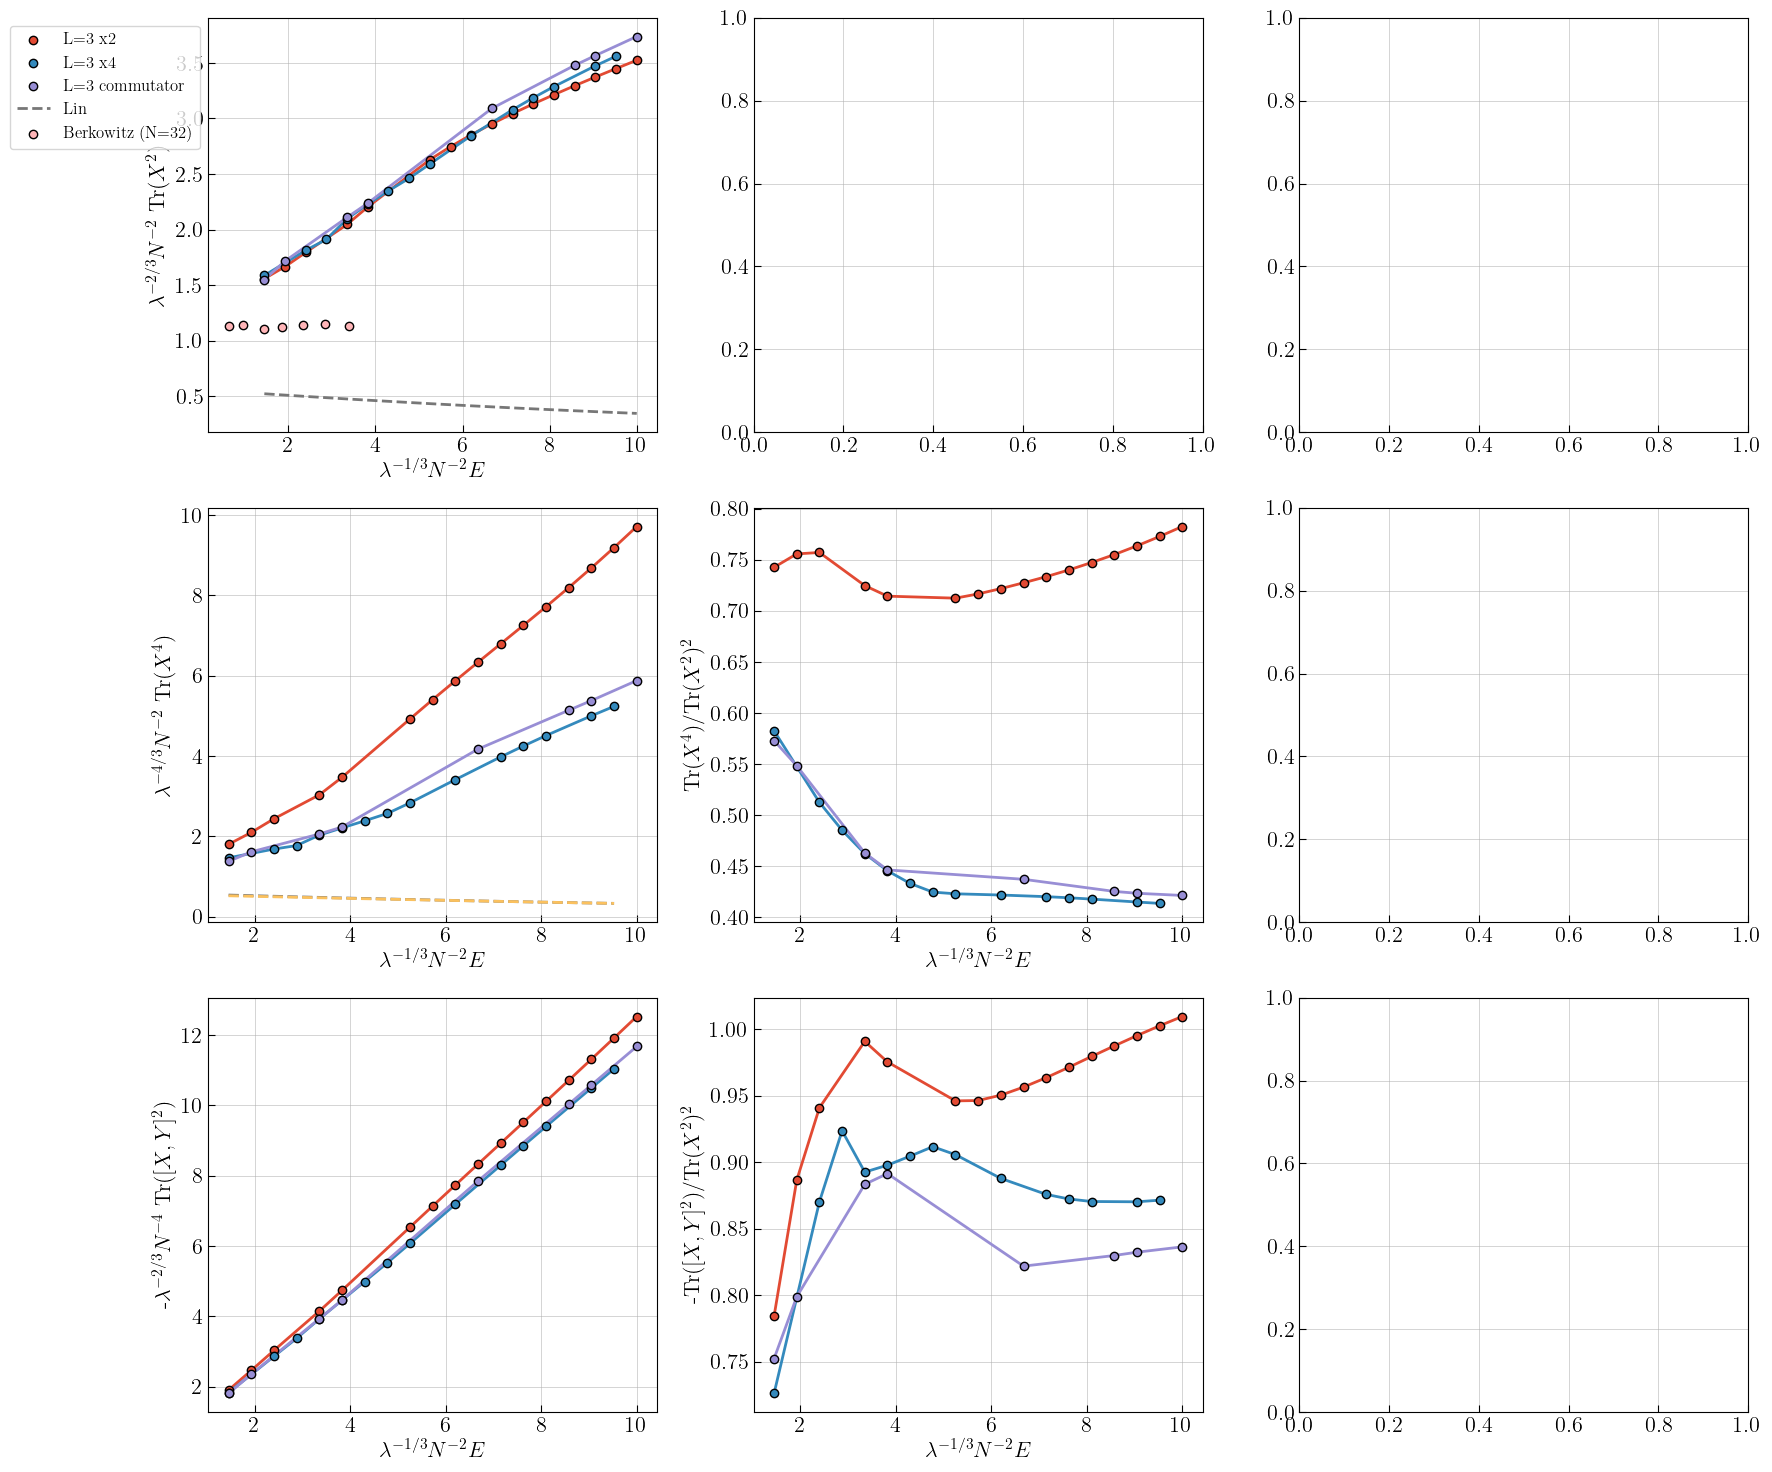

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(3*6, 3*5))

ax = axes[0,0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["x_2"])
    ax.scatter(df["energy"], df["x_2"], label='L=3 ' + name, edgecolor='k', zorder=10)
lower_bound = 3 * np.asarray([lin_lower_bound_x2(e) for e in df_x2["energy"]])
ax.plot(df_x2["energy"], lower_bound, '--', label='Lin')
ax.scatter(df_berkowitz["energy"], df_berkowitz["R squared"] / 3, label='Berkowitz (N=32)', edgecolor='k', zorder=10, color=colors[-1])
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_ylim([min(lower_bound), 1])
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
ax.legend(fontsize=12, bbox_to_anchor=(0,1))

ax = axes[1, 0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["x_4"])
    ax.scatter(df["energy"], df["x_4"], label='L=3 ' + name, edgecolor='k', zorder=10)
lower_bound = 3 * np.asarray([lin_lower_bound_x4(e) for e in df_x4["energy"]])
ax.plot(df_x4["energy"], 3 * lower_bound, '--', label='Lin')
lower_bound = 3 * np.asarray([lin_lower_bound_x4_bosonic(e) for e in df_x4["energy"]])
ax.plot(df_x4["energy"], 3 * lower_bound, '--', label='Lin (bosonic only)')
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-4/3} N^{-2}$ Tr$(X^4)$")

ax = axes[1, 1]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["x_4"]/df["x_2"]**2)
    ax.scatter(df["energy"], df["x_4"]/df["x_2"]**2, label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"Tr$(X^4)$/Tr$(X^2)^2$")

ax = axes[2, 0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["neg_commutator_squared"])
    ax.scatter(df["energy"], df["neg_commutator_squared"], label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"-$\lambda^{-2/3} N^{-4}$ Tr$([X, Y]^2)$")

ax = axes[2, 1]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["neg_commutator_squared"] / df["x_2"]**2)
    ax.scatter(df["energy"], df["neg_commutator_squared"] / df["x_2"]**2, label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"-Tr$([X, Y]^2)/$Tr$(X^2)^2$")

plt.tight_layout()
plt.show()